# Lab 1: Benchmarking data transformations and machine learning algorithms for cell type identification from single-cell RNAseq

In [1]:
# import base modules
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="ticks", font_scale=1)

seaborn (works on top of matplotlib) figure styles: [https://seaborn.pydata.org/tutorial/aesthetics.html#seaborn-figure-styles](https://seaborn.pydata.org/tutorial/aesthetics.html#seaborn-figure-styles)

# 1. Problem definition 

## 1.1 Data

We shall use the single cell gene expression of human peripheral blood mononuclear cells (PBMC) as prepared in Luecken et al., 2021 ([Benchmarking atlas-level data integration in single-cell genomics](https://www.nature.com/articles/s41592-021-01336-8).

Data comes from 2 studies:

Freytag et al., 2018: [Comparison of clustering tools in R for medium-sized 10x Genomics single-cell RNA-sequencing data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124389/)

Sun et al., 2019: [A Bayesian mixture model for clustering droplet-based single-cell transcriptomic data from population studies](https://www.nature.com/articles/s41467-019-09639-3)

## 1.2 Task


**In this tutorial, we'll first build a model for cell type classification using datasets within Sun et al., 2019 ("sun") and later also predict it on Freytag et al., 2019 ("freytag")**

## 1.3 Evaluation metrics

# overall accuracy

$acc = m/n$,
where,

$m$: Number of predictions where a label matches exactly with the ground truth, and

$n$: Number of total samples

Between 0 and 1. 1 is the best. By chance is 0.5 (in binary case).

## Balanced accuracy

balanced_acc is the average of recall per class.

$\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}},$ where

TP: True positive
TN: True negative
FP: False positive
FN: False negative

Between 0 and 1. 1 is the best. By chance: $\frac{1}{\text{number of classes}}$

# Read in the data

In [3]:
os.listdir("data")

['freytag_meta.csv',
 'sun_counts.pqt',
 'sun_meta.csv',
 'freytag_counts.pqt',
 '.ipynb_checkpoints']

The count data is large and is saved as parquet files which provides an efficient way to strore and read large data matrices among other things. 

"Apache Parquet is an open source, column-oriented data file format designed for efficient data storage and retrieval. It provides high performance compression and encoding schemes to handle complex data in bulk and is supported in many programming language and analytics tools." From [https://parquet.apache.org/](https://parquet.apache.org/)

In [4]:
# Sun

df = pd.read_parquet(os.path.join("data", "sun_counts.pqt"))
df_meta = pd.read_csv(os.path.join("data", "sun_meta.csv"), index_col=0)

In [5]:
print(f"count data size: {df.shape}")
print(f"metadata size: {df_meta.shape}")

count data size: (8829, 10851)
metadata size: (8829, 14)


Gene expression data consists of "counts" and the associated metadata. Below is a protocol on how this data is generated for a specific technology (10x Chromium)

![Single cell RNA sequencing](images/10xschematic.jpg "Title")

The result is a count matrix (a matrix of integer where each value indicates the copies of transcripts for each genes.)

In [6]:
# Print head of data
df.head()

index,LINC00115,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,...,COL6A1,COL6A2,LSS,MCM3AP-AS1,MCM3AP,YBEY,PCNT,DIP2A,S100B,PRMT2
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCACAGACAG-1-Sun_sample1_CS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAACGGGCAGTAGAGC-1-Sun_sample1_CS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGCATGGTAGG-1-Sun_sample1_CS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
AAACGGGGTTCCGTCT-1-Sun_sample1_CS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
AAACGGGTCATCGCTC-1-Sun_sample1_CS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0


The dataset has 8,829 cells and 10,851 genes.

In [7]:
# Print head of metadata
df_meta.head()

,batch,chemistry,data_type,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes,sample_ID,size_factors,species,study,tissue,cell_type
index,,,,,,,,,,,,,,
AAACCTGCACAGACAG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,NaN,CD4+ T cells,0.023411,5083.0,1269.0,3,1.050655,Human,Sun,PBMCs,CD4+ T cells
AAACGGGCAGTAGAGC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,NaN,CD4+ T cells,0.033540,4025.0,1314.0,3,1.179662,Human,Sun,PBMCs,CD4+ T cells
AAACGGGCATGGTAGG-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,NaN,CD4+ T cells,0.020093,5574.0,1246.0,3,1.050509,Human,Sun,PBMCs,CD4+ T cells
AAACGGGGTTCCGTCT-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,NaN,CD4+ T cells,0.021680,6227.0,1381.0,3,1.266189,Human,Sun,PBMCs,CD4+ T cells
AAACGGGTCATCGCTC-1-Sun_sample1_CS,Sun_sample1_CS,10X,UMI,NaN,CD4+ T cells,0.068300,8287.0,1892.0,3,1.758033,Human,Sun,PBMCs,CD4+ T cells


Our column of interest is "cell_type" which we will train models on.

In [8]:
# prepare X and y

X = df.copy() # changes made in X won't affect df. For dictionaries, use deepcopy()
y = df_meta["cell_type"]

In [9]:
# updated sizes
print(X.shape, y.shape)

(8829, 10851) (8829,)


# Data split

Create a training set and a test set.

Two rules apply:
1. There should be no leakage between the train and test set. If there are more samples from one patient, both samples should remain in the same split.
2. Test set should be sufficiently large to assess the performance.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# We'll do a 80-20 split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
for i in train_X, test_X, train_y, test_y:
    print(i.shape)

(7063, 10851)
(1766, 10851)
(7063,)
(1766,)


## Preprocessing and QC

Before we proceed with building a classifiers, there are some things to keep in mind:
    
1. There may be poor quality samples that we want to avoid learning from,
2. There may be some features that might be redundant, and 
3. In cases like this, we have more features than samples (10,851 vs 7,063). Such high dimensional data may be difficult for learners. This refers to "curse of dimensionality, especially when the data can not be represented appropriates in 3D physical spaces. For gene expression data, this is the case, however due to biology several genes can be associated with specific cell types. **Domain knowledge helps**!

Domain knowledge also helps in deciding on preprocessing.

### Removing atypical samples

First we will compute total genes expressed per sample

In [13]:
def count_genes(df):
    df_bool = df.astype(bool)
    exp_genes = df_bool.sum(axis=1)
    return exp_genes

def count_total_count(df):
    sums = df.sum(1)
    return sums

In [14]:
gene_counts, total_counts = count_genes(train_X), count_total_count(train_X)

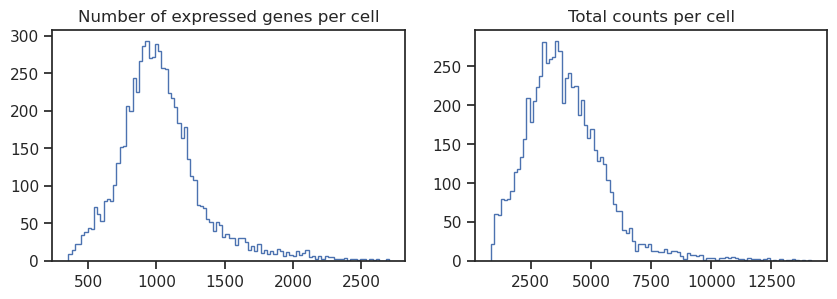

In [15]:
# We can plot these to see if there are some outliers

plt.figure(figsize=(10,3))
ax = plt.subplot(1,2,1)
ax.hist(gene_counts, histtype="step", bins=100)
ax.set_title("Number of expressed genes per cell")

# We can plot these to see if there are some outliers
ax = plt.subplot(1,2,2)
plt.hist(total_counts, histtype="step", bins=100)
plt.title("Total counts per cell")
plt.show()

<ins>Note</ins>: The choice of how to select outliers is mostly domain specific. In clinical data, it maybe "exceptionally atypical measurements", in financial data, it may be a specific month (April saw a reducing in US financial debt, so can't rely observations during that time, unless of course if that is your target. In cases, where such information is not possible, dedicated outlier detection methods can be utilized. [https://scikit-learn.org/stable/modules/outlier_detection.html](https://scikit-learn.org/stable/modules/outlier_detection.html)

From our training data, we will remove cells with total expressed genes between 500 and 2000 and with total genes per cell over 7500.

In [16]:
gene_min, gene_max = 500, 2000
count_max = 7500

In [17]:
idxs_rm = []
idxs_rm = gene_counts[(gene_counts<gene_min)&(gene_counts>gene_max)].index.tolist()
idxs_rm = idxs_rm + total_counts[total_counts>count_max].index.tolist()

In [18]:
print(len(idxs_rm))

223


In [19]:
train_X, train_y = train_X.drop(idxs_rm), train_y.drop(idxs_rm)

## Normalization

In [20]:
# domain specific (Make sure each cell has same total RNA)
train_X = train_X.div(train_X.sum(1), 0)  # Divide each value in a row by the row sum
train_X = train_X*1e6 
train_X = np.log2(train_X+1)

In [21]:
train_X.min().min(), train_X.max().max()

(0.0, 18.968884563660744)

This normalizes counts such that each cell's total count sums to 1 million and take log2 of it. Computing log2 makes really high gene expressions to be comparable to others. It's a lightweight way of mitigating gene expression disparity and also "approximates" a normal distribution (a nice property of have). In single-cell, "approximates" doesn't usually occur due to high sparsity i.e. many features are 0's (check with (train_X==0).sum()). This is not a settled issue. Several different approaches are possible and the science is not settled. Some normalizations are discussed in this review: [https://link.springer.com/article/10.1186/s12864-024-10364-5](https://link.springer.com/article/10.1186/s12864-024-10364-5)

In [22]:
(train_X==0).sum()

index
LINC00115    6758
NOC2L        5885
KLHL17       6816
PLEKHN1      6817
HES4         6654
             ... 
YBEY         6358
PCNT         6654
DIP2A        6145
S100B        6631
PRMT2        3962
Length: 10851, dtype: int64

So that the model weights each feature appropriately, we need to make the data such that each feature has same impact in theory.

After this, we have two standard routes to take

1. Min-Max normalization: Scale all values between 0 and 1: Appropriate when you expect uniformly distributed features
2. Mean-var or standard scaling: Zero center data: Appropriate when you expect "somewhat" normally distributed features

These can be sensitive to outliers. There are other "exotic" ways to normalize like based on median etc.

<ins>Note</ins>: Some algorithms like Random Forest are less sensitive to preprocessing and can handle data as it is as we'll see later on.

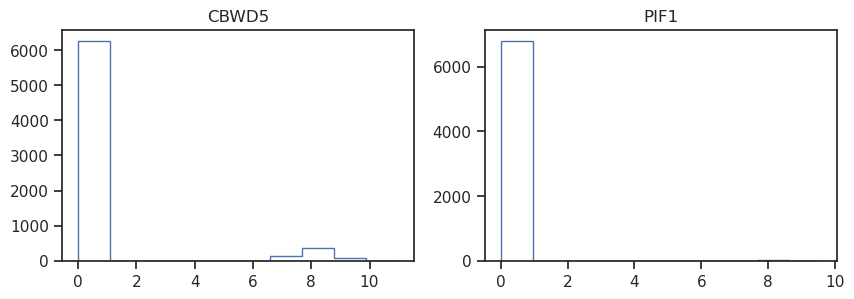

In [23]:
# Let's see the distribution of two genes and how they can differ

genes = np.random.choice(train_X.columns, 2)
plt.figure(figsize=(10,3))
ax = plt.subplot(1,2,1)
ax.hist(train_X[genes[0]], histtype="step", bins=10)
ax.set_title(genes[0])

# We can plot these to see if there are some outliers
ax = plt.subplot(1,2,2)
plt.hist(train_X[genes[1]], histtype="step", bins=10)
plt.title(genes[1])
plt.show()

In [24]:
# Here we'll generate three scalings and store data 

from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmaxscaler = MinMaxScaler() # This will store the computed parameters for the scaling
meanvarscaler = StandardScaler()

minmaxscaler.fit(train_X)
meanvarscaler.fit(train_X)

train_X_minmax = minmaxscaler.transform(train_X) # transform converts pandas dataframe to numpy array
train_X_meanvar = meanvarscaler.transform(train_X) # transform converts pandas dataframe to numpy array

train_X_minmax = pd.DataFrame(train_X_minmax, columns=train_X.columns, index=train_X.index) # reattach indices and columns
train_X_meanvar = pd.DataFrame(train_X_meanvar, columns=train_X.columns, index=train_X.index) # reattach indices and columns

In [25]:
# transform test set
test_X_minmax = minmaxscaler.transform(test_X) 
test_X_meanvar = meanvarscaler.transform(test_X) 

test_X_minmax = pd.DataFrame(test_X_minmax, columns=test_X.columns, index=test_X.index) # reattach indices and columns
test_X_meanvar = pd.DataFrame(test_X_meanvar, columns=test_X.columns, index=test_X.index) # reattach indices and columns

In [26]:
# parameters can be checked
print("Min Max scaler")
print(f"Min: {minmaxscaler.data_min_}")
print(f"Max: {minmaxscaler.data_max_}")
print(f"Shape of Min and Max: {minmaxscaler.data_min_.shape[0]}")

print("-----")
# parameters can be checked
print(f"Mean: {meanvarscaler.mean_}")
print(f"Var: {meanvarscaler.var_}")
print(f"Shape of Mean and Var: {meanvarscaler.mean_.shape[0]}")

Min Max scaler
Min: [0. 0. 0. ... 0. 0. 0.]
Max: [ 8.97154933 10.24218023  9.55086927 ... 10.92318296 12.57041028
 11.06187894]
Shape of Min and Max: 10851
-----
Mean: [0.09520964 1.13363265 0.02843088 ... 0.83848201 0.27343459 3.54945278]
Var: [ 0.74918476  7.96709673  0.23065692 ...  6.25453479  2.40668545
 17.57992874]
Shape of Mean and Var: 10851


## Further since we may have so-called "curse of dimensionality", we can take three approaches:

1. Do nothing: Use data as it is
2. Select highly variable genes, as they impact more the change in classes
3. Supervised feature selection
4. Do regularization while learning -> Not all methods can do that. Support vector machines, multilayered perceptrons can. RF can't.
3. Perform a dimensionality reduction technique: PCA, autoencoder (Autoencoders will be covered tomorrow).

In [27]:
def select_khvg(X, y, k=500):
    """
    Per cell type, select k most variable features (by standard deviation)
    """
    feats = []
    for e in y.unique():
        idxs_e = y[y==e].index
        sub_df = X.loc[idxs_e]
        stds = sub_df.std() # compute standard deviation
        stds.sort_values(ascending=False) # sort by decreasing order
        feats = feats + stds.index[:k].tolist()
    
    feats = list(set(feats)) # remove duplicated features
    return X[feats]

def do_pca():
    """
    Perform PCA with n components. See from here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    Remember to save the PCA class so that you can apply it on the test set. Similar to minmaxscalers
    Bonus: make informed choice about n.
    """
    pass

def do_sup():
    """
    Perform suprvised feature selection using method of your choice (Model based or univariate). 
    See from here https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
    """
    pass

In [28]:
train_X_meanvar_khvg = select_khvg(train_X_meanvar, train_y)

# train_X_pca = do_pca(...)
# train_X_sup = do_sup(...)

In [29]:
# Apply it on the test data

test_X_meanvar_khvg = test_X_meanvar[train_X_meanvar_khvg.columns]

# test_X_pca = ... # Hint: Apply PCA transform
# test_X_sup = ... # Hint: Will vary depending on the method of choice


## Build general optimizer

In [30]:
from sklearn.model_selection import RandomizedSearchCV
def optimize_clf(X, y, estimator, params, n_iter=10, cv=None, verbose=3, scoring="balanced_accuracy"):
    """
    Wraps around https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html and randomly searches over
        parameter distributions and scores each iteration
    
    X, y: train_X, train_y
    estimator: the classifier e.g. forest = RandomForestClassifier(random_state=42)
    params: dictionary containing parameter distributions
    n_iter: Number of iterations
    cv: k for k-fold cross validation, default 5
    verbose: Controls the verbosity: the higher, the more messages.
        >1 : the computation time for each fold and parameter candidate is displayed;
        >2 : the score is also displayed;
        >3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
    scoring: a string specifying method to use for scoring each run or callable function
    """
    cv = RandomizedSearchCV(estimator=estimator, param_distributions=params, n_iter=n_iter, cv=cv, verbose=verbose, scoring=scoring)
    cv.fit(X, y)
    return cv.best_params_, cv.best_estimator_

## Build classifiers

In [31]:
## Below, we call RandomForestClassifier class and optimize the hyperparameters on data with all genes and khvg
from sklearn.ensemble import RandomForestClassifier
forest1 = RandomForestClassifier(random_state=42)
forest2 = RandomForestClassifier(random_state=42)

In [32]:
# get params (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# We'll optimize two hyperparameters
params = {'max_depth': [5, 10, 15, 20],
          'min_samples_split': [5, 10, 20]}

In [34]:
best_params_all, best_estimator_all = optimize_clf(train_X_meanvar, train_y, forest1, params, verbose=3)
best_params_khvg, best_estimator_khvg = optimize_clf(train_X_meanvar_khvg, train_y, forest2, params, verbose=3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=20, min_samples_split=20;, score=0.714 total time=   9.8s
[CV 2/5] END max_depth=20, min_samples_split=20;, score=0.662 total time=   9.8s
[CV 3/5] END max_depth=20, min_samples_split=20;, score=0.689 total time=   9.7s
[CV 4/5] END max_depth=20, min_samples_split=20;, score=0.723 total time=   9.8s
[CV 5/5] END max_depth=20, min_samples_split=20;, score=0.678 total time=   9.8s
[CV 1/5] END .max_depth=10, min_samples_split=5;, score=0.720 total time=   6.5s
[CV 2/5] END .max_depth=10, min_samples_split=5;, score=0.649 total time=   6.5s
[CV 3/5] END .max_depth=10, min_samples_split=5;, score=0.678 total time=   6.5s
[CV 4/5] END .max_depth=10, min_samples_split=5;, score=0.708 total time=   6.5s
[CV 5/5] END .max_depth=10, min_samples_split=5;, score=0.666 total time=   6.5s
[CV 1/5] END .max_depth=5, min_samples_split=20;, score=0.406 total time=   3.5s
[CV 2/5] END .max_depth=5, min_samples_split=20;

In [35]:
print("Best params")
print(f"All genes: {best_params_all}")
print(f"khvg: {best_params_khvg}")

Best params
All genes: {'min_samples_split': 5, 'max_depth': 20}
khvg: {'min_samples_split': 5, 'max_depth': 20}


Q: Number of samples required to split a node is less for khvg. Why do you think that could be?

## Save models

In [36]:
model_dir = "models"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [37]:
import joblib
joblib.dump(best_params_all, os.path.join(model_dir, "meanvar_rf_best_all.pkl"))
joblib.dump(best_params_khvg, os.path.join(model_dir, "meanvar_rf_best_khvg.pkl"))

['models/meanvar_rf_best_khvg.pkl']

In [38]:
# Models are now "portable", always keep in mind the sklearn version, else could be issue with reproducibility in another machine
import sklearn
print(sklearn.__version__)

1.3.0


In [39]:
# Make predictions

preds_X_meanvar_all = best_estimator_all.predict(test_X_meanvar)
preds_X_meanvar_khvg = best_estimator_khvg.predict(test_X_meanvar_khvg)
# .predict() method returns numpy arrays, but dataframes are human readble (tables).

preds_X_meanvar_all = pd.DataFrame(preds_X_meanvar_all, index=test_X.index, columns=["cell_type"])
preds_X_meanvar_khvg = pd.DataFrame(preds_X_meanvar_khvg, index=test_X.index, columns=["cell_type"])

## save predictions

In [40]:
preds_dir = "models"

if not os.path.exists(preds_dir):
    os.mkdir(preds_dir)

In [41]:
preds_X_meanvar_all.to_csv(os.path.join(preds_dir, "preds_meanvar_rf_best_all.csv"))
preds_X_meanvar_khvg.to_csv(os.path.join(preds_dir, "preds_meanvar_rf_best_khvg.csv"))


## compute metrics

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [43]:
# create a metrics dir

metrics_dir = "metrics"
if not os.path.exists(metrics_dir):
    os.mkdir(metrics_dir)

In [44]:
def get_scores(preds, true, classes, run_name="rf", metrics_dir="metrics"):
    """
    Compute accuracy, balanced accuracy and confusion matrices
    preds: model output
    true: ground truth classes
    classes: class labels (accessible from .classes_ method from the classifier)
    run_name: Attach a readable run name in index of the accuracy dataframe for later use
    """
    acc = accuracy_score(preds, true)
    print(f"Accuracy: {acc}")
    balanced_acc = balanced_accuracy_score(preds, true)
    print(f"Balanced accuracy: {balanced_acc}")
    print(pd.DataFrame([acc, balanced_acc]))
    df_acc = pd.DataFrame([acc, balanced_acc], columns=[run_name], index=["accuracy", "balanced accuracy"])
    cm = confusion_matrix(preds, true)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    
    df_acc.to_csv(os.path.join(metrics_dir, f"scores_{run_name}.csv"))
    df_cm.to_csv(os.path.join(metrics_dir, f"cm_{run_name}.csv"))
    return df_acc, df_cm

In [45]:
df_acc, df_cm = get_scores(preds_X_meanvar_all["cell_type"], test_y, best_estimator_all.classes_, "meanvar_rf_best_all")

Accuracy: 0.5962627406568517
Balanced accuracy: 0.8384054975340876
          0
0  0.596263
1  0.838405


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [46]:
_, _ = get_scores(preds_X_meanvar_khvg["cell_type"], test_y, best_estimator_all.classes_, "meanvar_rf_best_khvg")

Accuracy: 0.5062287655719139
Balanced accuracy: 0.7212633695215118
          0
0  0.506229
1  0.721263


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Q: why the user warning?

In [47]:
## Plot the metrics

dfs = []
for run_name in ["meanvar_rf_best_all", "meanvar_rf_best_khvg"]:
    dfs.append(pd.read_csv(os.path.join(metrics_dir, f"scores_{run_name}.csv"), index_col=0))
df = pd.concat(dfs, axis=1)

<Axes: >

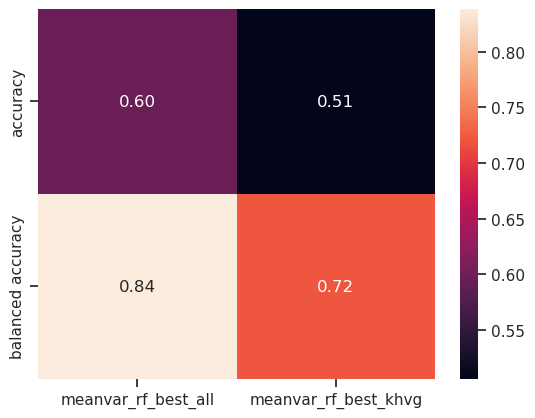

In [48]:
sns.heatmap(df, fmt=".2f", annot=True)

# Task: 

1. Add f1 score to our metrics function, re-run and save the metrics by adding F1 score to the saved dataframe containing the metrics & write equation below.
(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
f1 score: ...

<ins>Hint:</ins> LaTeX works with jupyter markdown in general. You can use $$ to write LaTeX.

2. For random forest, we can assess the most important features. Create a dataframe with genes ranked by their feature importances

<ins>Hint</ins>: .feature_importances_ attribute from the random forest classifier will return an array of importances for each feature. The order of features remains same as in train_X.

Q: How would you compute feature importance per cell type?

3. Do the same as above for the following classifiers: 

Classifiers:

a. Support vector classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC \
b. Linear support vector classifier with l1 regularization: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC \
c. Multi-layered perceptron: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html \


Subtasks:

3.1. Optimize the classifier on train set using cross-validation \
3.2. Save the model \
3.2. Predict on test set \
3.3. save results \

# Bonus #1: Lab

Choose the best classifier, build it on Sun again and predict on freytag.

<ins>Hint</ins>: You will need to subset both the dataset so that they contain same gene.

# Bonus #2: Lab

Write a function to compute metrics per class.

<ins>Hint</ins>: You will need to run the functions per class, easiest to do in a lopp.


# Bonus #2: Reading and lab

RandomForestClassifier provides feature importances at a global level (i.e. not per sample), while many other algorithms like MLPs do not provide any inherent interpretability. To compute exact or approximated importances or interpretability, SHAP [https://shap.readthedocs.io/en/latest/](https://shap.readthedocs.io/en/latest/) provides a nice framework that is model-agnostic. 

For tree based models, SHAP provides exact computation of Shapley values [https://en.wikipedia.org/wiki/Shapley_value](https://en.wikipedia.org/wiki/Shapley_value). Paper for the second part: Lundberg et al., 2020 [https://www.nature.com/articles/s42256-019-0138-9](https://www.nature.com/articles/s42256-019-0138-9)

## 2.2 Outliers
